### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_64_layer1_filters_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [3]:
batch_size = 32
target_size = (200,200)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

holdout_generator = test_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [4]:
model=Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0

In [5]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch_64_layer1_filters.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 1000,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
61/61 [==============================] - 188s 3s/step - loss: 3.3031 - accuracy: 0.2040 - val_loss: 1.7647 - val_accuracy: 0.2478
Epoch 2/1000
61/61 [==============================] - 182s 3s/step - loss: 1.5906 - accuracy: 0.3629 - val_loss: 1.7203 - val_accuracy: 0.2301
Epoch 3/1000
61/61 [==============================] - 181s 3s/step - loss: 1.4924 - accuracy: 0.3948 - val_loss: 1.6945 - val_accuracy: 0.2537
Epoch 4/1000
61/61 [==============================] - 181s 3s/step - loss: 1.3860 - accuracy: 0.4542 - val_loss: 1.6213 - val_accuracy: 0.3835
Epoch 5/1000
61/61 [==============================] - 176s 3s/step - loss: 1.2413 - accuracy: 0.5108 - val_loss: 1.5205 - val_accuracy: 0.4041
Epoch 6/1000
61/61 [==============================] - 181s 3s/step - loss: 1.2723 - accuracy: 0.4930 - val_loss: 1.6076 - val_accuracy: 0.3510
Epoch 7/1000
61/61 [==============================] - 177s 3s/step - loss: 1.1719 - accuracy: 0.5341 - val_loss: 1.6364 - val_accuracy: 0.2832

In [6]:
score = model.evaluate(holdout_generator, verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.7569721341133118


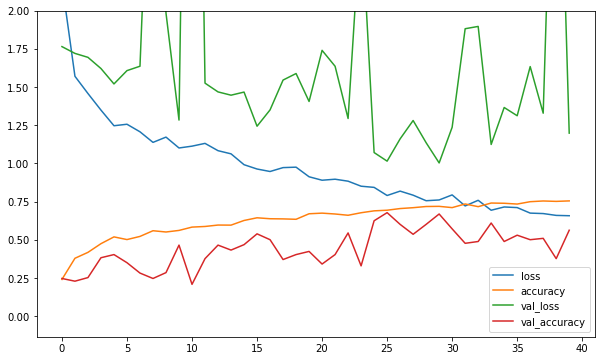

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=2)
plt.legend();

In [13]:
max(history.history['val_accuracy'])

0.6784660816192627